In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
### Установим красивые дефолтные настройки
### Может быть лень постоянно прописывать
### У графиков параметры цвета, размера, шрифта
### Можно положить их в словарь дефолтных настроек

import matplotlib as mlp

# mlp.rcParams['lines.linewidth'] = 5

# mlp.rcParams['xtick.major.size'] = 20
# mlp.rcParams['xtick.major.width'] = 5
# mlp.rcParams['xtick.labelsize'] = 20
# mlp.rcParams['xtick.color'] = '#FF5533'

# mlp.rcParams['ytick.major.size'] = 20
# mlp.rcParams['ytick.major.width'] = 5
# mlp.rcParams['ytick.labelsize'] = 20
# mlp.rcParams['ytick.color'] = '#FF5533'

# mlp.rcParams['axes.labelsize'] = 20
# mlp.rcParams['axes.titlesize'] = 20
# mlp.rcParams['axes.titlecolor'] = '#00B050'
# mlp.rcParams['axes.labelcolor'] = '#00B050'

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Gradient Boosting

In [21]:
### Генерим датасет

from sklearn.datasets import make_moons

dataset = make_moons(n_samples=1000,
                     noise=0.5,
                     random_state=0)

dataset = pd.DataFrame(np.hstack((dataset[0], dataset[1].reshape(-1, 1))),
                       columns=["x1", "x2", "y"])

dataset.head()

,x1,x2,y
0,2.216430,0.741684,1.0
1,2.057427,0.424853,1.0
2,-0.116847,0.004159,0.0
3,-0.710797,0.210482,1.0
4,0.267548,-0.460654,1.0


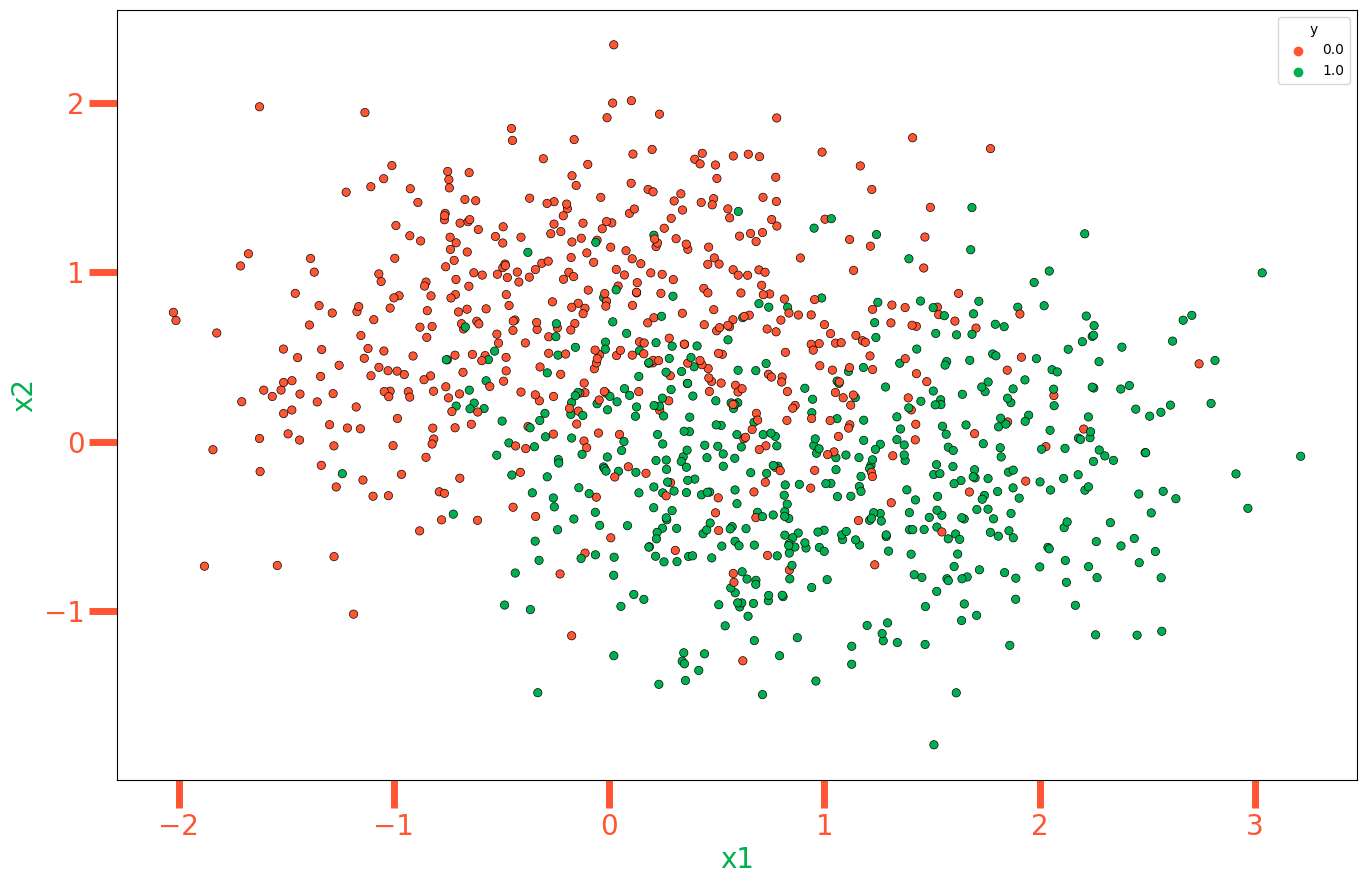

In [22]:
### Изобразим объекты и раскрасим их в классы

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.scatterplot(x="x1",
                y="x2",
                hue="y",
                edgecolor="k",
                palette=["#FF5533", "#00B050"],
                data=dataset)

plt.show()

In [23]:
### Разобьем датасет на объекты и таргеты

X = dataset.drop("y", axis=1)
y = dataset["y"]

### Разделим на трейн и тест

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0, 
                                                    test_size=0.2)


In [24]:
### Обучим градиентный бустинг над деревьями

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=1,
                                   max_depth=2,
                                   n_estimators=500)

model

GradientBoostingClassifier(learning_rate=1, max_depth=2, n_estimators=500)

In [25]:
model.n_estimators

500

In [26]:
def learn_boosting_and_plot(estimator=model,
                            X_tr=X_train,
                            X_te=X_test,
                            Y_tr=y_train,
                            Y_te=y_test):
    
    pixel_step = 0.02
    
    X = pd.concat((X_tr, X_te))
    Y = pd.concat((Y_tr, Y_te))
    
    x1_min, x1_max = X.values[:, 0].min() - 1, X.values[:, 0].max() + 1
    x2_min, x2_max = X.values[:, 1].min() - 1, X.values[:, 1].max() + 1

    ### Генерим много-много точек на плоскости

    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, pixel_step),
        np.arange(x2_min, x2_max, pixel_step)
    )

    
    ### Обучаем модель на трейне
    
    estimator.fit(X_tr, Y_tr)
    
    ### Считаем качество на обоих фолдах
    
    accuracy_train = estimator.score(X_tr, Y_tr)
    accuracy_test = estimator.score(X_te, Y_te)
    
    ### Для каждой точки даем прогноз, чтобы покрыть поверхности

    Z = estimator.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    ### Заполняем пространство

    cs = plt.contourf(xx1, xx2, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    ### Рисуем точечки и обученные области

    for i, n, c in zip(range(2), model.classes_, ["#FF5533", "#00B050"]):
        idx = np.where(y == i)
        plt.scatter(
            X.values[idx, 0],
            X.values[idx, 1],
            c=c,
            s=20,
            edgecolor="k",
            label="Class %s" % n,
        )
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.legend(loc="upper right")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Boosting with {estimator.n_estimators} estimators")
    
    return accuracy_train, accuracy_test

(1.0, 0.755)

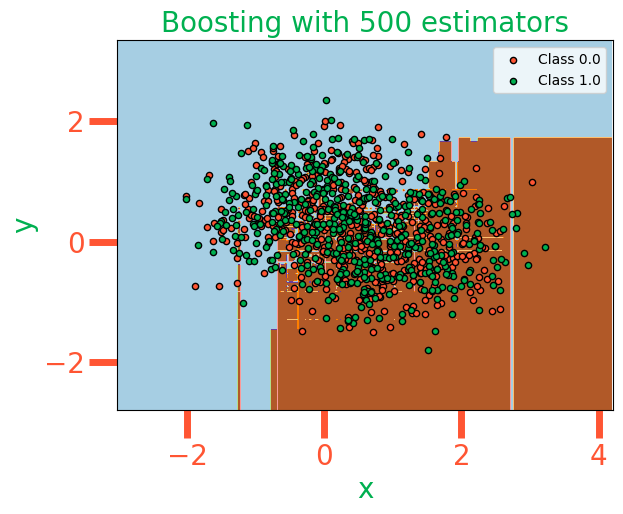

In [27]:
learn_boosting_and_plot(model)

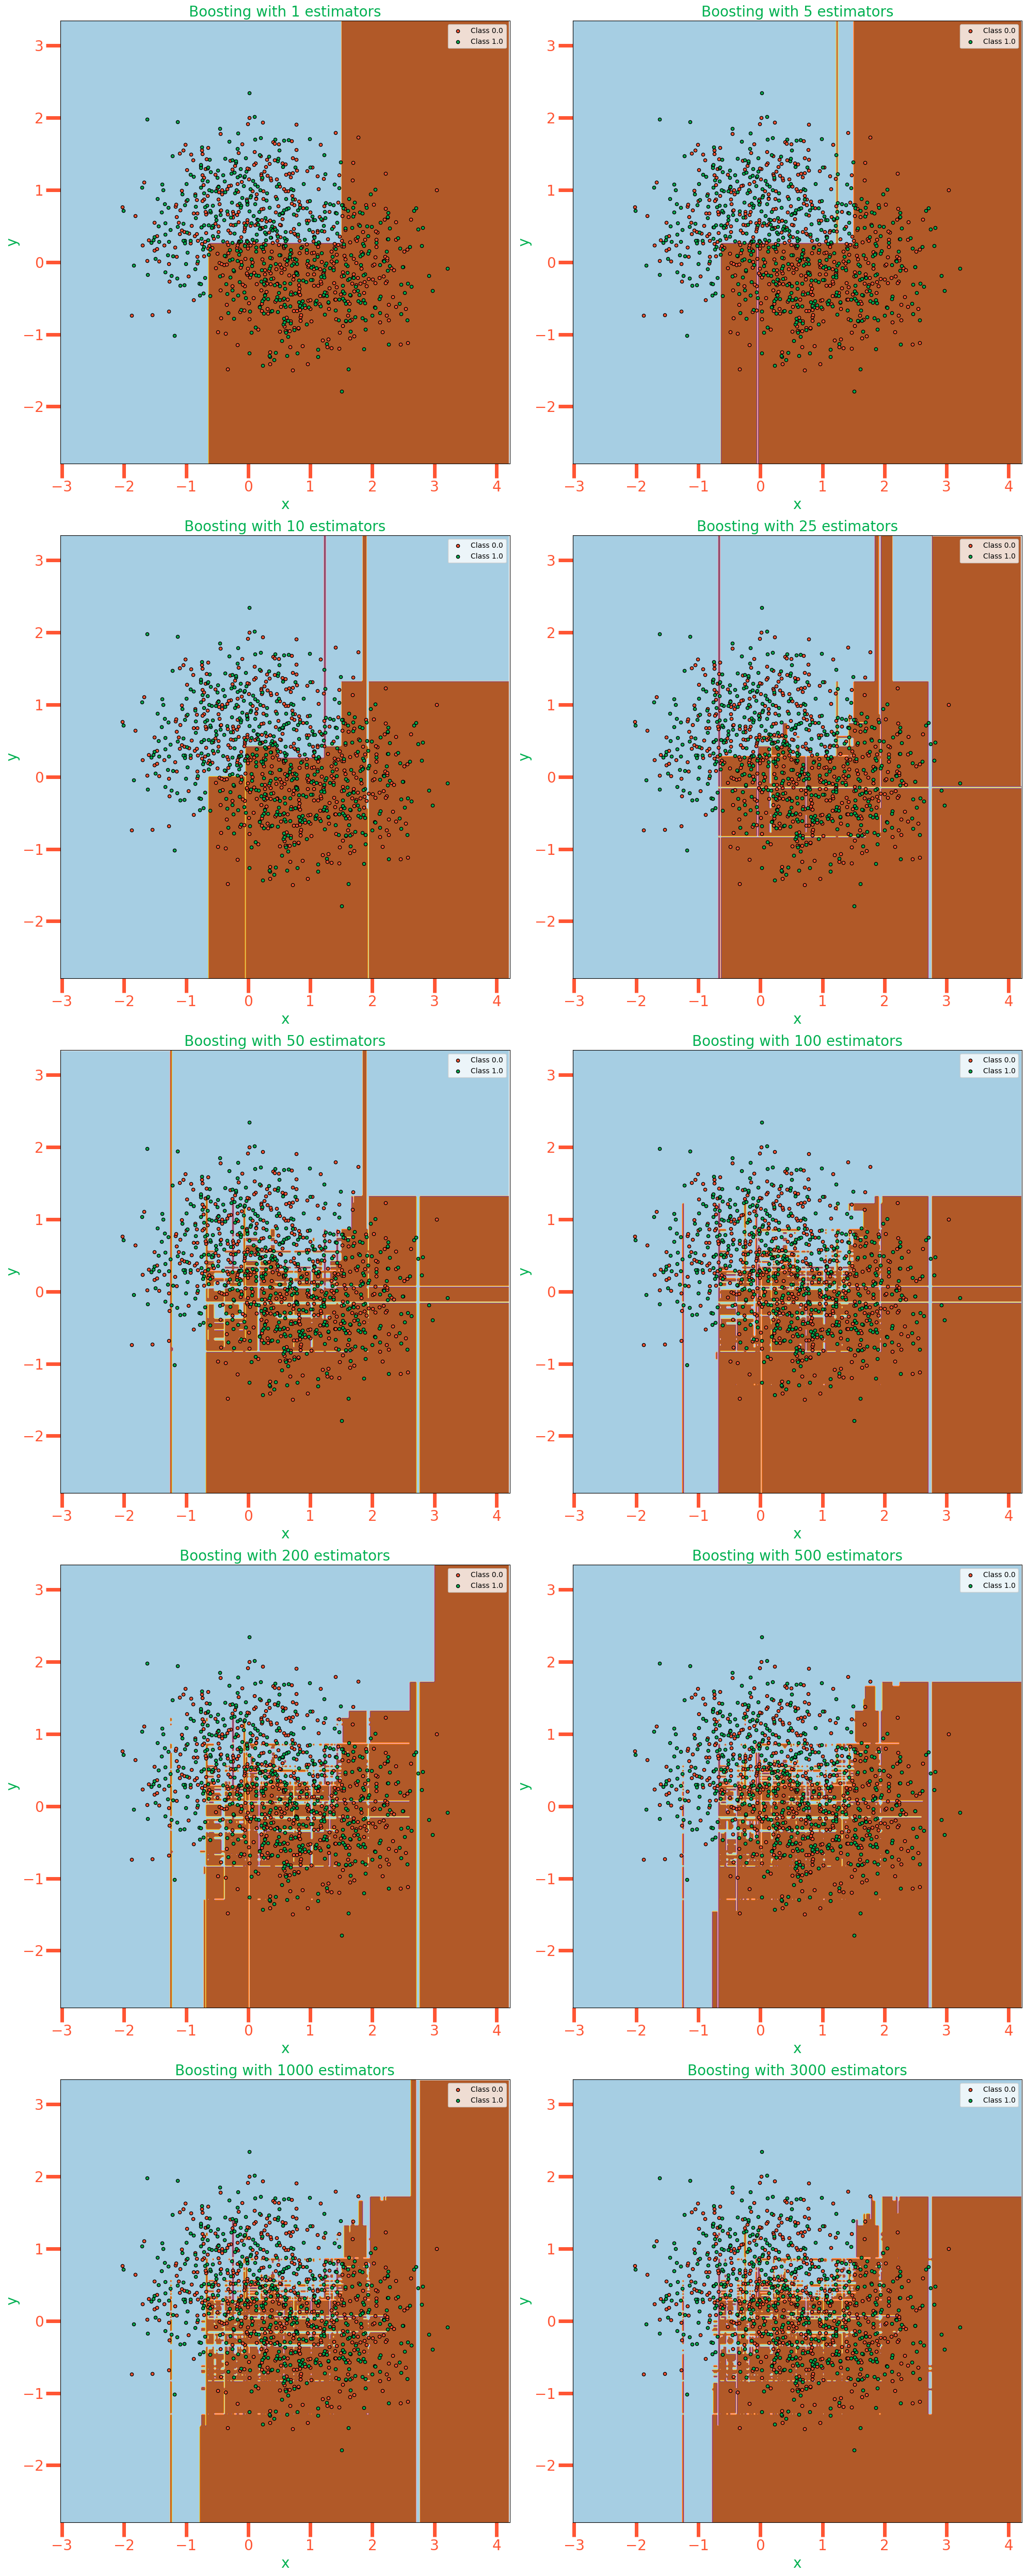

In [28]:
estimators_num = [1, 5, 10, 25, 50, 100, 200, 500, 1000, 3000]

fig = plt.figure()
fig.set_size_inches(20, 50)

train_accuracies = []
test_accuracies = []


for i, s in enumerate(estimators_num):
    
    model.n_estimators = s
    ax_ = fig.add_subplot(5, 2, i+1)
    
    outputs = learn_boosting_and_plot(model)
    
    train_accuracies.append(outputs[0])
    test_accuracies.append(outputs[1])

fig.tight_layout()
plt.show()

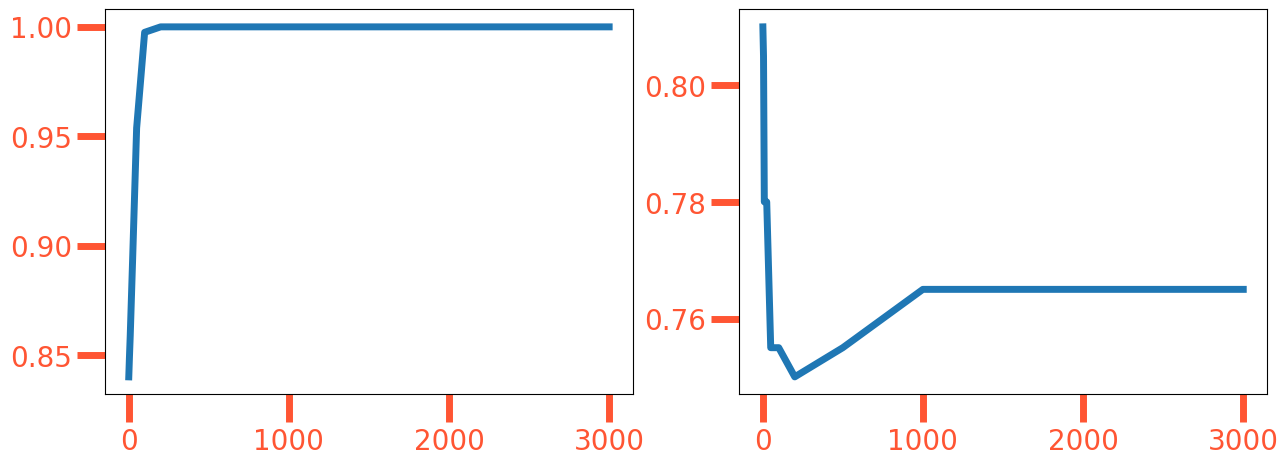

In [29]:
### Изобразим кривые качества на трейне и тесте

fig = plt.figure()
fig.set_size_inches(15, 5)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(estimators_num, train_accuracies)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(estimators_num, test_accuracies)

plt.show()

### Поменяем learning_rate и посмотрим, как замедлится композиция!

In [30]:
### Обучим градиентный бустинг над деревьями

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=0.1,
                                   max_depth=2,
                                   n_estimators=500)

model

GradientBoostingClassifier(max_depth=2, n_estimators=500)

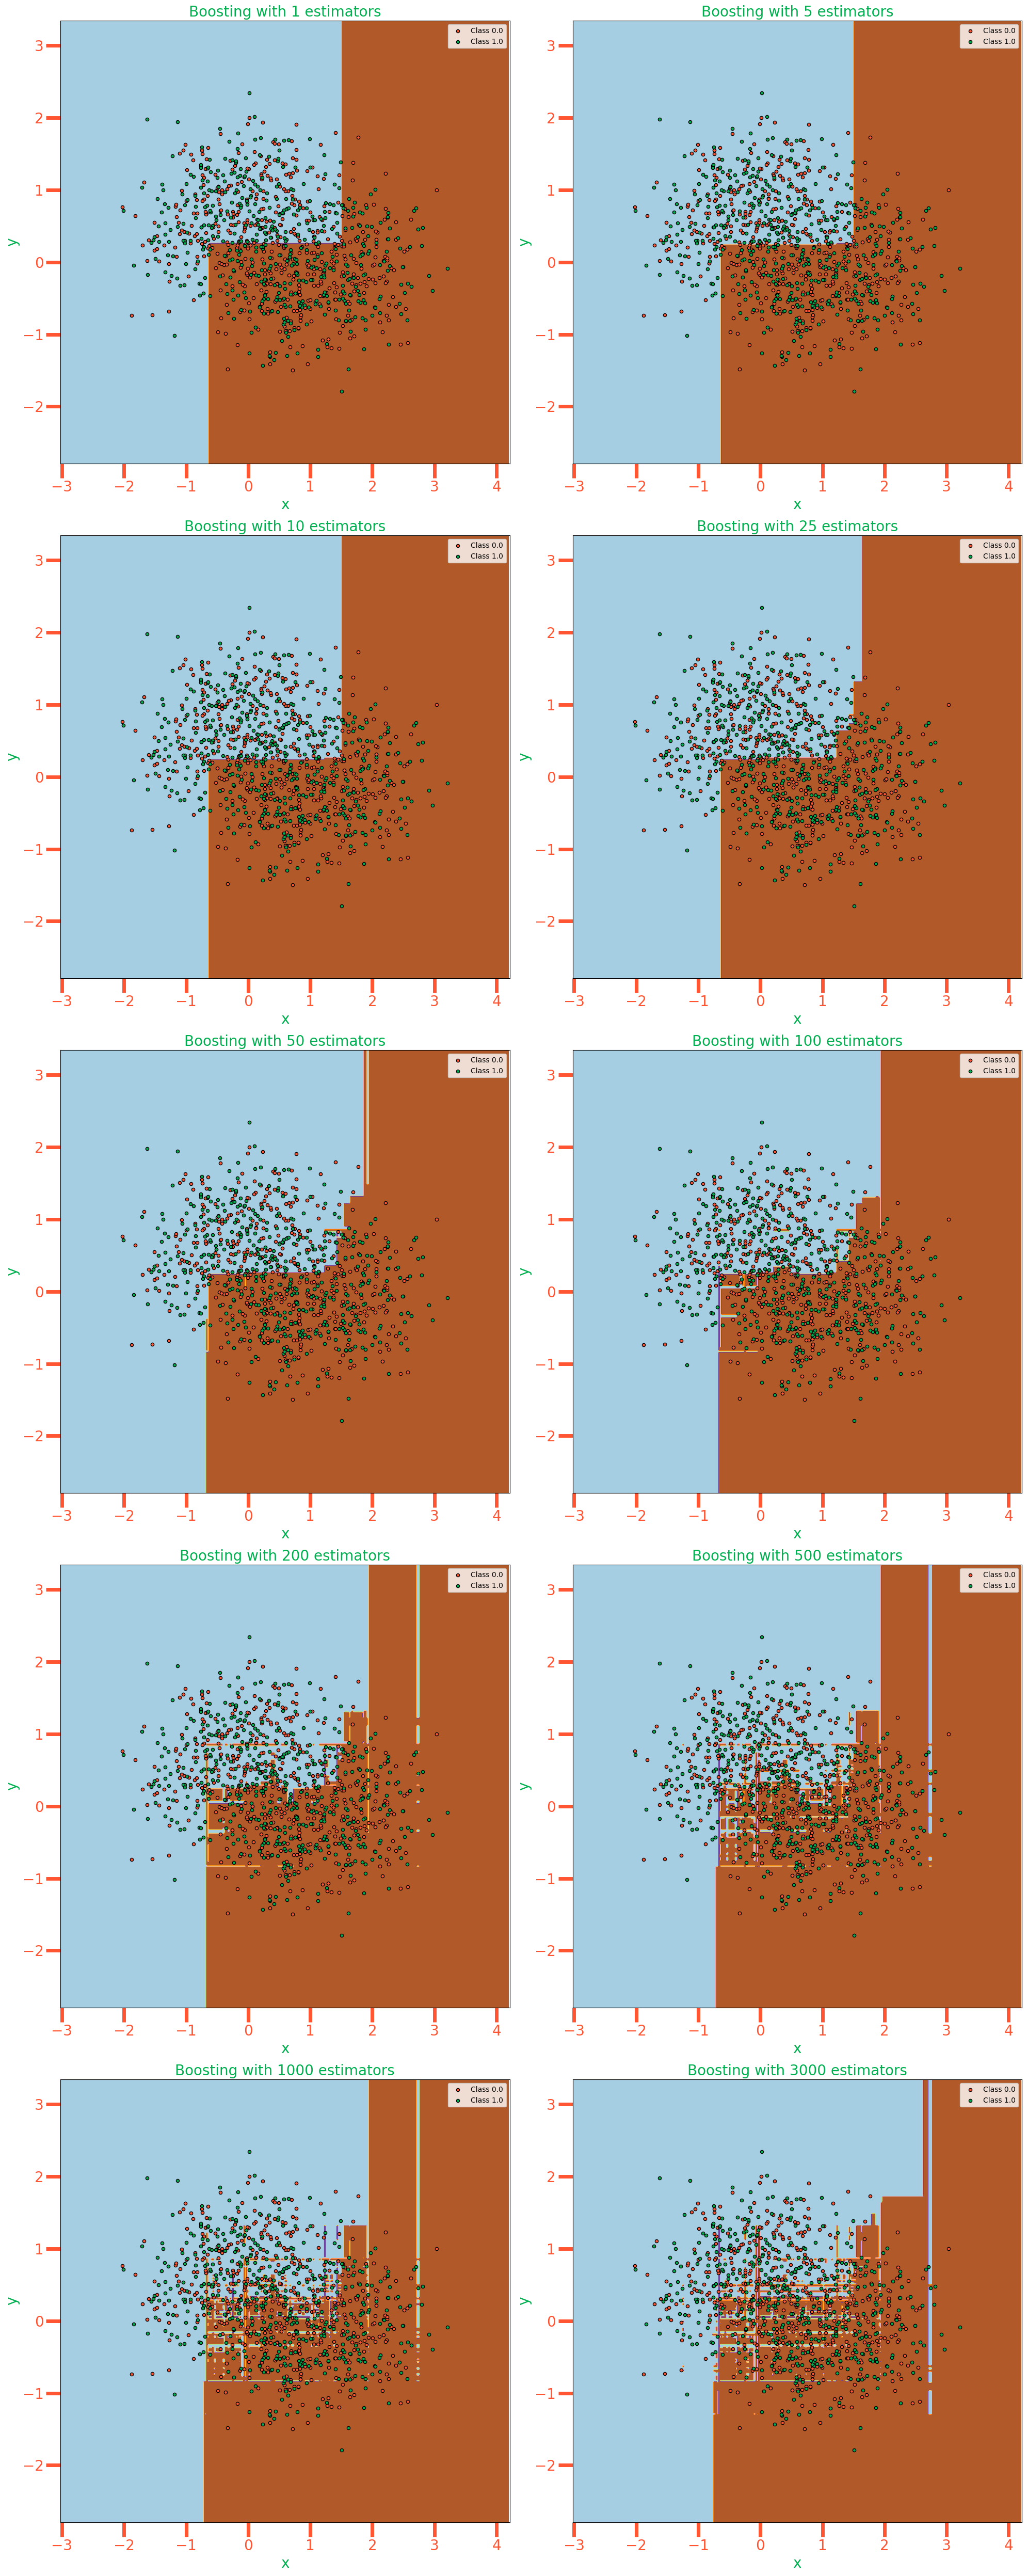

In [31]:
estimators_num = [1, 5, 10, 25, 50, 100, 200, 500, 1000, 3000]

fig = plt.figure()
fig.set_size_inches(20, 50)

train_accuracies = []
test_accuracies = []


for i, s in enumerate(estimators_num):
    
    model.n_estimators = s
    ax_ = fig.add_subplot(5, 2, i+1)
    
    outputs = learn_boosting_and_plot(model)
    
    train_accuracies.append(outputs[0])
    test_accuracies.append(outputs[1])

fig.tight_layout()
plt.show()

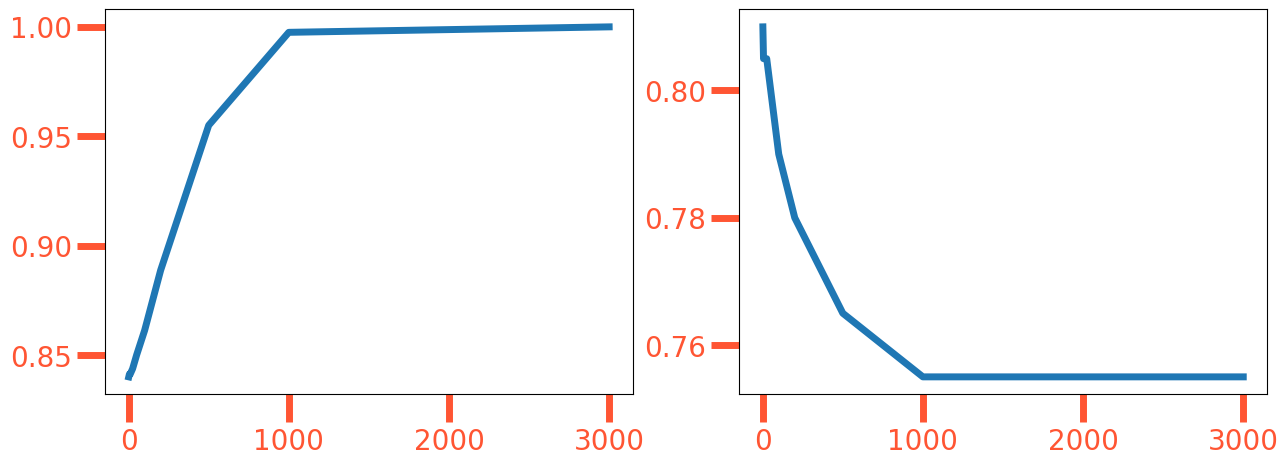

In [32]:
### Изобразим кривые качества на трейне и тесте

fig = plt.figure()
fig.set_size_inches(15, 5)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(estimators_num, train_accuracies)

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(estimators_num, test_accuracies)

plt.show()

### Популярные реализации градиентного бустинга

### XGboost

$$
\sum_i^n L(y_i, a^{(N-1)}(x_i) + b_N (x_i)) \rightarrow min
$$

Ряд Тейлора:

$$
e^x = 1 + \frac{x}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} + ...
$$

Можно применять и в многомерном случае

$$
\sum_i^n L(y_i, a^{(N-1)}(x_i) + b_N (x_i)) \approx \sum_i^n (L(y_i, a^{(N-1)}(x_i)) - s_i \cdot b(x_i) + \frac{1}{2}\cdot h_i \cdot b^2(x_i))
$$

где через $h_i$ обозначены вторые производные по сдвигам

Если вместо $h_i$ положить единички, то получится ровно та задача аппроксимации сдвигов, которую решает обычный градиентный бустинг:

$$
\sum_i^n (b(x_i)-s_i)^2 = \sum_i^n (b^2(x_i) - 2\cdot s_i \cdot b(x_i) + s_i^2) = 
$$

$$
\sum_i^n ( - 2\cdot s_i \cdot b(x_i) + b^2(x_i) + s_i^2) = 2 \cdot \sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i) + \frac{1}{2} + s_i^2)
$$

При оптимизации константы как множитель и как слагаемое можно опустить:

$$
\sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i)) \rightarrow min
$$

Таким образом, XGboost совершенствует классический градиентный бустинг тем фактом, что при приближении сдвигов новым алгоритмом еще и учитывает вторые производные (кривизну) изначально минимизируемого функционала. Так же в XGboost реализациях обычно учитывается регуляризация деревьев типа

$$
\sum_i^n (- s_i \cdot b(x_i) + \frac{1}{2} \cdot b^2 (x_i)) + \gamma \cdot J + \frac{\lambda}{2}\cdot \sum_j^J b_j^2 \rightarrow min
$$

Считается самым оптимизированным бустингом: огромное комьюнити, перебор порогов осуществляется с некоторым шагом, а не полным перебором и т.д.

### Catboost

Реализация Яндекса, обладающая рядом особенностей:

1. Симметричные деревья
2. Встроенная обработка категориальных признаков
3. Позволяет строить вершины с большим количеством потомков (например, может классно работать при наличии категорий с большим количеством уникальных значений)
4. Бустрапирует выборку при обучении
5. и т.д.

Наверное, стоит сказать, что это лучшее решение, работающее из коробки без особого подбора гиперпараметров.

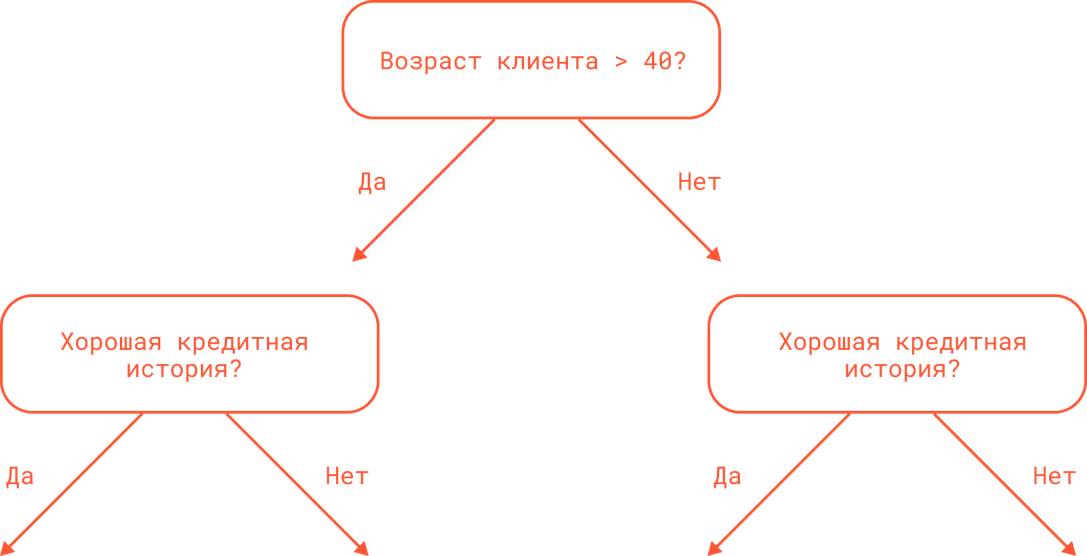

### LightGBM

Разработка Microsoft! 

1. С точки зрения работы с категориями, делит их на 2 подгруппы и работает как с бинарной категорией
2. Строит односторонние деревья, из-за чего почти всегда опережает остальные реализации по скорости работы

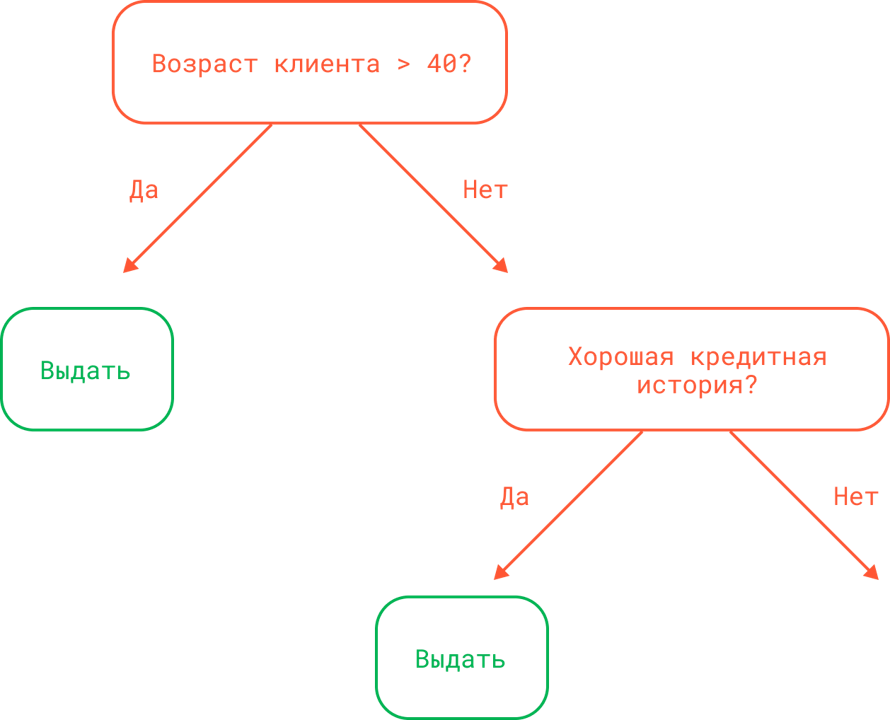

### Бустинг в реальной задаче и сравнение результатов с бэггингом

In [33]:
X_train = pd.read_csv("X_train_updated.csv")
X_test = pd.read_csv("X_test_updated.csv")

y_train = pd.read_csv("y_train_updated.csv")
y_test = pd.read_csv("y_test_updated.csv")

object_cols = ['store_nbr', 'item_nbr', 'onpromotion', 'month',
               'city', 'state', 'type', 'cluster', 'family',
               'class', 'perishable', 'holiday_type', 'locale',
               'locale_name', 'description', 'transferred']

X_test[object_cols] = X_test[object_cols].astype(str)
X_train[object_cols] = X_train[object_cols].astype(str)

cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]
numeric_cols = list(X_train.select_dtypes(exclude='object').columns)

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
numeric_cols_idx = [list(X_train.columns).index(col) for col in numeric_cols]

cat_cols = cols_for_ohe_idx + cols_for_mte_idx

FileNotFoundError: [Errno 2] No such file or directory: 'X_train_updated.csv'

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor()

catboost.fit(X_train, y_train, cat_features=cat_cols)

In [ ]:
### Замерим качество работы такой модели
### Возьмем MSLE

train_preds = catboost.predict(X_train)
test_preds = catboost.predict(X_test)

train_error = np.mean((train_preds - y_train.values.ravel())**2)
test_error = np.mean((test_preds - y_test.values.ravel())**2)


print(f"Качество на трейне: {train_error.round(3)}")
print(f"Качество на тесте: {test_error.round(3)}")